In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib import patches

from detection.inference.detector import lesion_detector
from detectron2.structures import boxes
import numpy as np

# SET dataset

The SET dataset form Mexico of 33 patients will be used to assess the performance of the model on a test set outiside of the original distribution.<br>
- SEt images are slightly different to DE, but maintains a similar pixel distribution so we expect similar performance.

In [10]:
def check_inside_contained(box_out, box_in):
    # check if box_in is inside box_out
    if (box_in[0] > box_out[0]) and (box_in[1] > box_out[1]) and (box_in[2] < box_out[2]) and (box_in[3] < box_out[3]):
        return True
    else:
        return False

def return_instance_to_remove(predicted_boxes, predicted_scores):
    for instance_i, bbox_i in enumerate(predicted_boxes):
        for instance_j, bbox_j in enumerate(predicted_boxes):
            if instance_i != instance_j:
                if check_inside_contained(box_out=bbox_i, box_in=bbox_j):
                    # print(f'box {instance_j} is inside box {instance_i}')
                    if predicted_scores[instance_i] > predicted_scores[instance_j]:
                        return instance_j
                    else:
                        return instance_i
                    
def pick_insideoutside_contrained(predicted_boxes, predicted_scores):
    while True:
        removable_idex = return_instance_to_remove(predicted_boxes, predicted_scores)
        if removable_idex is None:
            break
        # remove instance
        predicted_boxes = np.delete(predicted_boxes, removable_idex, axis=0)
        predicted_scores = np.delete(predicted_scores, removable_idex)

    return predicted_boxes, predicted_scores

def post_process_pred(out):

    predicted_boxes = out.pred_boxes.tensor.numpy()
    predicted_scores = out.scores.numpy()

    predicted_boxes, predicted_scores = pick_insideoutside_contrained(predicted_boxes, predicted_scores)

    # substitute the prediction with the new one
    new_out = out[:len(predicted_boxes)]
    new_out.pred_boxes = boxes.Boxes(predicted_boxes)
    new_out.scores = predicted_scores

    return new_out


In [4]:
config_file = repo_path / 'detection/training/data/config_files/fine_tuning_CEM.yaml'
mod_num = '04'
# model_file = repo_path / f'detection/training/results/real-synth_improved/model_00{mod_num}999.pth' # fine-tuned 2
model_file = repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth'
min_score = 0.1 # minimum score threshold to keep the prediction

# inputs
im_dir = repo_path / 'data/SET-Mex/images/substracted_jpg'
metadata_path = repo_path / 'data/SET-Mex/metadata/SET_png_metadata.csv'

detector = lesion_detector(config_file, model_file, metadata_path, im_dir, min_score)

[03/05 12:18:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth ...


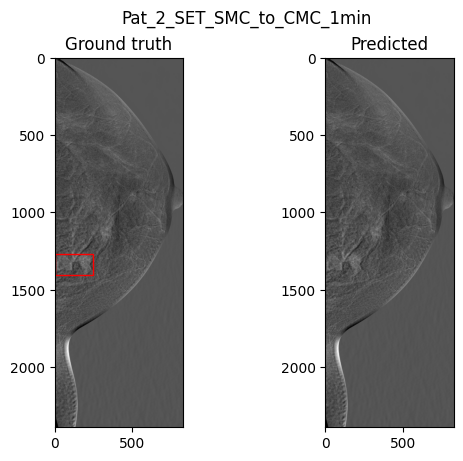

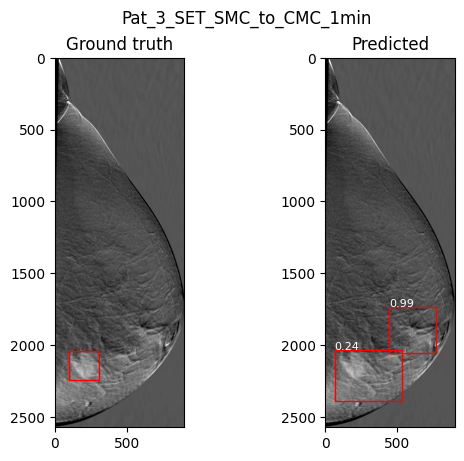

In [11]:
for im_name in detector.test_df['image_name'].unique()[0:2]:

    im_bboxes = detector.test_df[detector.test_df['image_name']==im_name] # filter bboxes for this image
    bboxes_info = [eval(bbox) for bbox in im_bboxes['bbox']] # get all regions bboxes
    gt_bboxes = [[bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]] for bbox in bboxes_info]

    # read image
    im_path = detector.im_dir / f'{im_name}.png'
    im_array = cv.imread(str(im_path))

    # prediction
    outputs = detector.predictor(im_array)
    out = outputs["instances"].to("cpu")

    # out = post_process_pred(out)


    # show all bounding boxes on the image
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(im_array)
    ax[0].set_title('Ground truth')
    for bbox in gt_bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]), width = bbox[2]-bbox[0], height = bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(rect)
    ax[1].imshow(im_array)
    ax[1].set_title('Predicted')
    for i, bbox in enumerate(out.pred_boxes):
        rect = patches.Rectangle((bbox[0],bbox[1]), width = bbox[2]-bbox[0], height = bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(rect)
        # add score
        ax[1].text(bbox[0],bbox[1],f'{out.scores[i]:.2f}', color='white', fontsize=8)
    # set figure tilte
    fig.suptitle(im_name)
    plt.show()

# Computing FROC

We will compute the FROc as described in the CEM detection paper and the similar to the AIA microcalcification approach.

In [3]:
# Define model
config_file = repo_path / 'detection/training/data/config_files/fine_tuning_CEM.yaml'
mod_num = '04'
# model_file = repo_path / f'detection/training/results/real-synth_improved/model_00{mod_num}999.pth' # fine-tuned 2
model_file = repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth'
min_score = 0.1 # minimum score threshold to keep the prediction

#inputs
im_dir = repo_path / 'data/SET-Mex/images/substracted_jpg'
metadata_path = repo_path / 'data/SET-Mex/metadata/SET_png_metadata.csv'

detector = lesion_detector(config_file, model_file, metadata_path, im_dir, min_score)

[03/05 12:26:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth ...


    Remember the prediction will be make per image

In [8]:
#image example
detector.c_im_name = detector.test_df['image_name'].unique()[0]
# prepare current im and gt
detector.prepare_im_gt()
detector.c_im_array

(2389, 829, 3)